<a href="https://colab.research.google.com/github/shobharanip/Transformer_tennis_paper/blob/main/Sports_AI_paper2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from pyarrow import parquet as pq
import dask.dataframe as dd
from google.colab import files
import pandas as pd
import os

In [2]:
#!pip install xgboost

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
cd '/content/drive/MyDrive/Sports_AI/Input files/'

/content/drive/MyDrive/Sports_AI/Input files


In [7]:
#file_path = '/content/drive/MyDrive/Sports_AI/Sports_AI - Output files/Final_Labeled_Scored_Data.xlsx'

In [8]:
import os

# Define the path you want to check
path = '/content/drive/MyDrive/Sports_AI/Input files/'  # You can change this to any path you want to check

# List all files and directories in the specified path
files_in_path = os.listdir(path)

# Print the files and directories
print(f"Files and directories in '{path}':")
for file in files_in_path:
    print(file)


Files and directories in '/content/drive/MyDrive/Sports_AI/Input files/':
AlexMartinez
DiegoLaporta
FranciscoErramuspe
FranciscoLlanes
GabrielBusato
HanaMcKinney
MateoBivol
NitikaGirish
YoavWeinberg
my_transformer_model.py
__pycache__
train_self_supervised.py
detect_anomalies.py


In [9]:
# Define the file path
file_path = '/content/drive/MyDrive/Sports_AI/Final_Labeled_Scored_Data.xlsx'

In [10]:
# Load the file into a DataFrame
df = pd.read_excel(file_path)
# Display the first 5 rows of the DataFrame
print(df.head(5))

   Activity Strain Activity name  Altitude change (meters)  \
0             14.6        Tennis                       NaN   
1             14.6        Tennis                       NaN   
2             14.6        Tennis                       NaN   
3             14.6        Tennis                       NaN   
4             14.6        Tennis                       NaN   

   Altitude gain (meters)  Answered yes  Asleep duration (min)_x  \
0                     NaN           1.0                      364   
1                     NaN           1.0                      364   
2                     NaN           1.0                      364   
3                     NaN           1.0                      364   
4                     NaN           1.0                      364   

   Asleep duration (min)_y  Average HR (bpm)_x  Average HR (bpm)_y  \
0                    364.0                  76               131.0   
1                    364.0                  76               131.0   
2       

In [11]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from xgboost import XGBRegressor, XGBClassifier
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    accuracy_score,
    roc_auc_score,
    f1_score,
    confusion_matrix
)

# File Path
file_path = '/content/drive/MyDrive/Sports_AI/Final_Labeled_Scored_Data.xlsx'

def load_and_prepare_data(file_path):
    """Loads the data, handles potential missing values, and prepares data for regression and classification."""
    df = pd.read_excel(file_path)

    # Handle missing values properly to avoid chained assignment warnings
    for col in df.columns:
        if df[col].dtype in ['float64', 'int64']:
            df[col] = df[col].fillna(df[col].mean())

    # Define features and targets
    regression_features = ['Jump - Jump Height (in)_x', 'Activity Strain', 'Altitude gain (meters)']
    regression_target = 'Recovery score %'

    classification_features = ['Activity Strain', 'Average HR (bpm)_x']
    classification_target = 'Answered yes'

    # Convert classification target to binary if needed
    if df[classification_target].dtype != 'bool':
        df[classification_target] = df[classification_target].astype(int)

    return df, regression_features, regression_target, classification_features, classification_target

def train_and_evaluate_models(df, regression_features, regression_target, classification_features, classification_target):
    """Trains and evaluates the models."""

    # Split data for regression
    X_reg = df[regression_features]
    y_reg = df[regression_target]
    X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

    # Split data for classification
    X_clf = df[classification_features]
    y_clf = df[classification_target]
    X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X_clf, y_clf, test_size=0.2, random_state=42)

    # Models to train
    models = {
        "Linear Regression": {
            "model": LinearRegression(),
            "X_train": X_train_reg,
            "X_test": X_test_reg,
            "y_train": y_train_reg,
            "y_test": y_test_reg,
            "type": "regression"
        },
        "XGBoost Regressor": {
            "model": XGBRegressor(),
            "X_train": X_train_reg,
            "X_test": X_test_reg,
            "y_train": y_train_reg,
            "y_test": y_test_reg,
            "type": "regression"
        },
        "Logistic Regression": {
            "model": LogisticRegression(),
            "X_train": X_train_clf,
            "X_test": X_test_clf,
            "y_train": y_train_clf,
            "y_test": y_test_clf,
            "type": "classification"
        },
        "XGBoost Classifier": {
            "model": XGBClassifier(),
            "X_train": X_train_clf,
            "X_test": X_test_clf,
            "y_train": y_train_clf,
            "y_test": y_test_clf,
            "type": "classification"
        }
    }

    # Train and evaluate each model
    for model_name, model_data in models.items():
        print(f"\nTraining and Evaluating {model_name}...")
        model = model_data["model"]
        X_train = model_data["X_train"]
        X_test = model_data["X_test"]
        y_train = model_data["y_train"]
        y_test = model_data["y_test"]
        model.fit(X_train, y_train)

        if model_data["type"] == "regression":
            predictions = model.predict(X_test)
            mae = mean_absolute_error(y_test, predictions)
            rmse = np.sqrt(mean_squared_error(y_test, predictions))  # Fixed here
            r2 = r2_score(y_test, predictions)
            print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}, R-squared: {r2:.4f}")

        elif model_data["type"] == "classification":
            predictions = model.predict(X_test)
            accuracy = accuracy_score(y_test, predictions)
            f1 = f1_score(y_test, predictions)
            print(f"Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")

            if hasattr(model, "predict_proba"):
                probabilities = model.predict_proba(X_test)[:, 1]
                auc = roc_auc_score(y_test, probabilities)
                print(f"AUC-ROC: {auc:.4f}")

            conf_matrix = confusion_matrix(y_test, predictions)
            print("Confusion Matrix:")
            print(conf_matrix)

# Main Execution
if __name__ == "__main__":
    if os.path.exists(file_path):
        df, reg_features, reg_target, clf_features, clf_target = load_and_prepare_data(file_path)
        train_and_evaluate_models(df, reg_features, reg_target, clf_features, clf_target)
    else:
        print(f"Error: File not found at '{file_path}'")



Training and Evaluating Linear Regression...
MAE: 14.0511, RMSE: 16.8413, R-squared: 0.0090

Training and Evaluating XGBoost Regressor...
MAE: 3.8215, RMSE: 6.8145, R-squared: 0.8378

Training and Evaluating Logistic Regression...
Accuracy: 0.8488, F1 Score: 0.0000
AUC-ROC: 0.5457
Confusion Matrix:
[[14058     0]
 [ 2505     0]]

Training and Evaluating XGBoost Classifier...
Accuracy: 0.8515, F1 Score: 0.1003
AUC-ROC: 0.6947
Confusion Matrix:
[[13967    91]
 [ 2368   137]]



Training and Evaluating Linear Regression...
MAE: 14.0511, RMSE: 16.8413, R-squared: 0.0090


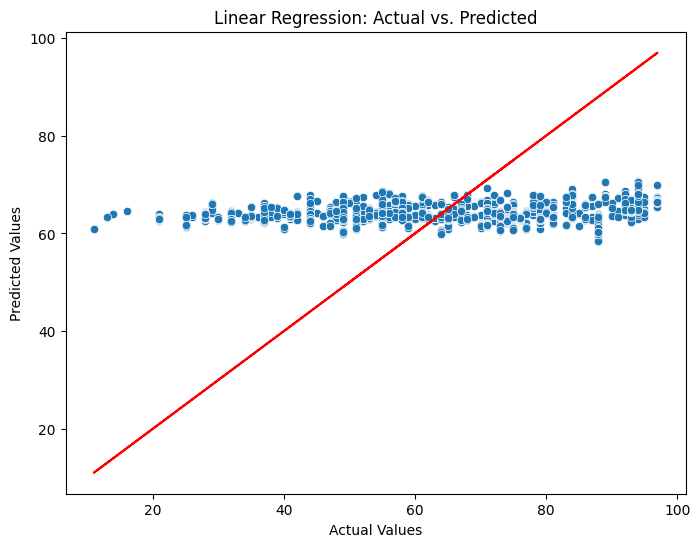


Training and Evaluating XGBoost Regressor...
MAE: 3.8215, RMSE: 6.8145, R-squared: 0.8378

Training and Evaluating Decision Tree Regressor...
MAE: 3.7528, RMSE: 6.8217, R-squared: 0.8374

Training and Evaluating Random Forest Regressor...
MAE: 3.7606, RMSE: 6.8194, R-squared: 0.8375

Training and Evaluating Logistic Regression...
Accuracy: 0.8488, F1 Score: 0.0000
AUC-ROC: 0.5457


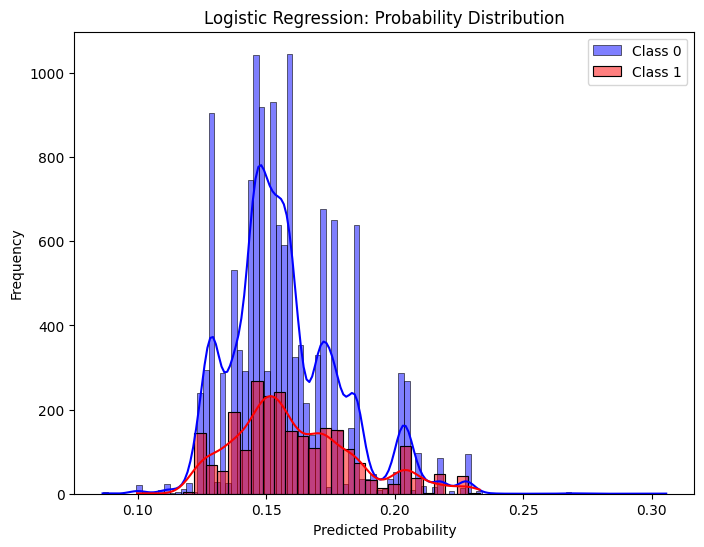

Confusion Matrix:
[[14058     0]
 [ 2505     0]]

Training and Evaluating XGBoost Classifier...
Accuracy: 0.8515, F1 Score: 0.1003
AUC-ROC: 0.6947
Confusion Matrix:
[[13967    91]
 [ 2368   137]]


<Figure size 1000x600 with 0 Axes>

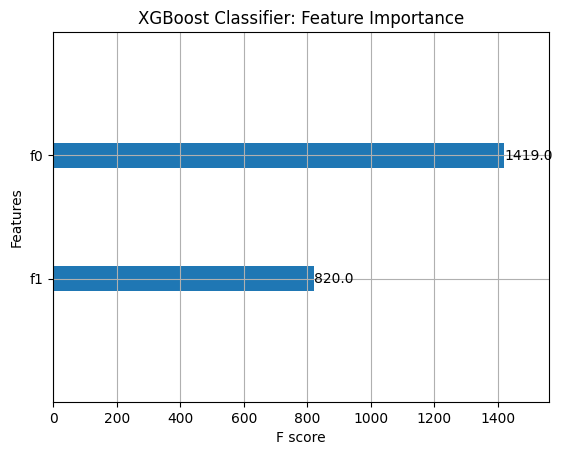

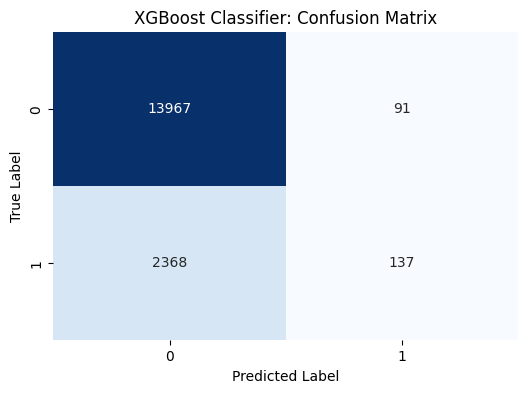


Training and Evaluating Decision Tree Classifier...
Accuracy: 0.8514, F1 Score: 0.1176
AUC-ROC: 0.6944
Confusion Matrix:
[[13938   120]
 [ 2341   164]]

Training and Evaluating Random Forest Classifier...
Accuracy: 0.8514, F1 Score: 0.1208
AUC-ROC: 0.6941
Confusion Matrix:
[[13933   125]
 [ 2336   169]]


In [12]:
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from xgboost import XGBRegressor, XGBClassifier, plot_importance
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    accuracy_score,
    roc_auc_score,
    f1_score,
    confusion_matrix,
)
import matplotlib.pyplot as plt
import seaborn as sns

# File Path
file_path = '/content/drive/MyDrive/Sports_AI/Final_Labeled_Scored_Data.xlsx'

# --- Data Loading and Preparation ---
def load_and_prepare_data(file_path):
    df = pd.read_excel(file_path)

    for col in df.columns:
        if df[col].dtype in ['float64', 'int64']:
            df[col] = df[col].fillna(df[col].mean())  # FIXED: avoid chained assignment warning

    regression_features = ['Jump - Jump Height (in)_x', 'Activity Strain', 'Altitude gain (meters)']
    regression_target = 'Recovery score %'

    classification_features = ['Activity Strain', 'Average HR (bpm)_x']
    classification_target = 'Answered yes'

    if df[classification_target].dtype != 'bool':
        df[classification_target] = df[classification_target].astype(int)

    return df, regression_features, regression_target, classification_features, classification_target

# --- Model Training and Evaluation ---
def train_and_evaluate_models(df, regression_features, regression_target, classification_features, classification_target):
    X_reg = df[regression_features]
    y_reg = df[regression_target]
    X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
        X_reg, y_reg, test_size=0.2, random_state=42
    )

    X_clf = df[classification_features]
    y_clf = df[classification_target]
    X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
        X_clf, y_clf, test_size=0.2, random_state=42
    )

    scaler_reg = StandardScaler()
    X_train_reg = scaler_reg.fit_transform(X_train_reg)
    X_test_reg = scaler_reg.transform(X_test_reg)

    scaler_clf = StandardScaler()
    X_train_clf = scaler_clf.fit_transform(X_train_clf)
    X_test_clf = scaler_clf.transform(X_test_clf)

    models = {
        "Linear Regression": {
            "model": LinearRegression(),
            "features": X_train_reg,
            "target": y_train_reg,
            "type": "regression",
            "test_features": X_test_reg,
            "feature_names": regression_features
        },
        "XGBoost Regressor": {
            "model": XGBRegressor(),
            "features": X_train_reg,
            "target": y_train_reg,
            "type": "regression",
            "test_features": X_test_reg,
            "feature_names": regression_features
        },
        "Decision Tree Regressor": {
            "model": DecisionTreeRegressor(random_state=42),
            "features": X_train_reg,
            "target": y_train_reg,
            "type": "regression",
            "test_features": X_test_reg,
            "feature_names": regression_features
        },
        "Random Forest Regressor": {
            "model": RandomForestRegressor(random_state=42),
            "features": X_train_reg,
            "target": y_train_reg,
            "type": "regression",
            "test_features": X_test_reg,
            "feature_names": regression_features
        },
        "Logistic Regression": {
            "model": LogisticRegression(),
            "features": X_train_clf,
            "target": y_train_clf,
            "type": "classification",
            "test_features": X_test_clf,
            "feature_names": classification_features
        },
        "XGBoost Classifier": {
            "model": XGBClassifier(),
            "features": X_train_clf,
            "target": y_train_clf,
            "type": "classification",
            "test_features": X_test_clf,
            "feature_names": classification_features
        },
        "Decision Tree Classifier": {
            "model": DecisionTreeClassifier(random_state=42),
            "features": X_train_clf,
            "target": y_train_clf,
            "type": "classification",
            "test_features": X_test_clf,
            "feature_names": classification_features
        },
        "Random Forest Classifier": {
            "model": RandomForestClassifier(random_state=42),
            "features": X_train_clf,
            "target": y_train_clf,
            "type": "classification",
            "test_features": X_test_clf,
            "feature_names": classification_features
        }
    }

    for model_name, model_data in models.items():
        print(f"\nTraining and Evaluating {model_name}...")
        model = model_data["model"]
        model.fit(model_data["features"], model_data["target"])
        X_test = model_data["test_features"]

        if model_data["type"] == "regression":
            predictions = model.predict(X_test)
            mae = mean_absolute_error(y_test_reg, predictions)
            rmse = np.sqrt(mean_squared_error(y_test_reg, predictions))  # FIXED: manually compute RMSE
            r2 = r2_score(y_test_reg, predictions)
            print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}, R-squared: {r2:.4f}")

            if model_name == "Linear Regression":
                plt.figure(figsize=(8, 6))
                sns.scatterplot(x=y_test_reg, y=predictions)
                plt.plot(y_test_reg, y_test_reg, color='red')
                plt.xlabel("Actual Values")
                plt.ylabel("Predicted Values")
                plt.title(f"Linear Regression: Actual vs. Predicted")
                plt.show()

        elif model_data["type"] == "classification":
            predictions = model.predict(X_test)
            accuracy = accuracy_score(y_test_clf, predictions)
            f1 = f1_score(y_test_clf, predictions)
            print(f"Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")

            if hasattr(model, "predict_proba"):
                probabilities = model.predict_proba(X_test)[:, 1]
                auc = roc_auc_score(y_test_clf, probabilities)
                print(f"AUC-ROC: {auc:.4f}")

                if model_name == "Logistic Regression":
                    plt.figure(figsize=(8, 6))
                    sns.histplot(probabilities[y_test_clf == 0], color='blue', label='Class 0', kde=True)
                    sns.histplot(probabilities[y_test_clf == 1], color='red', label='Class 1', kde=True)
                    plt.xlabel("Predicted Probability")
                    plt.ylabel("Frequency")
                    plt.title("Logistic Regression: Probability Distribution")
                    plt.legend()
                    plt.show()

            conf_matrix = confusion_matrix(y_test_clf, predictions)
            print("Confusion Matrix:")
            print(conf_matrix)

            if model_name == "XGBoost Classifier":
                plt.figure(figsize=(10, 6))
                plot_importance(model, importance_type='weight')
                plt.title("XGBoost Classifier: Feature Importance")
                plt.show()

                plt.figure(figsize=(6, 4))
                sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
                plt.xlabel("Predicted Label")
                plt.ylabel("True Label")
                plt.title("XGBoost Classifier: Confusion Matrix")
                plt.show()

# --- Entry Point ---
if __name__ == "__main__":
    if os.path.exists(file_path):
        df, reg_features, reg_target, clf_features, clf_target = load_and_prepare_data(file_path)
        train_and_evaluate_models(df, reg_features, reg_target, clf_features, clf_target)
    else:
        print(f"Error: File not found at '{file_path}'")


transformer_model.py

In [13]:
import torch
import torch.nn as nn

class TimeAwareTransformer(nn.Module):
    def __init__(self, input_dim, hidden_dim=512, num_layers=4, num_heads=8, dropout=0.1):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, hidden_dim)
        self.cls_token = nn.Parameter(torch.randn(1, 1, hidden_dim))
        self.pos_embed = nn.Parameter(torch.randn(1, 5, hidden_dim))

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim, nhead=num_heads, dropout=dropout, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.mfr_head = nn.Sequential(
            nn.Linear(hidden_dim, 256),
            nn.GELU(),
            nn.Linear(256, input_dim)
        )

        self.nwp_head = nn.Sequential(
            nn.Linear(hidden_dim, 256),
            nn.GELU(),
            nn.Linear(256, input_dim)
        )

        self.mask_token = nn.Parameter(torch.randn(input_dim))

    def forward(self, x, mask_indices=None, task='mfr'):
        B, T, D = x.shape

        if task == 'mfr' and mask_indices is not None:
            x = x.clone()
            for b in range(B):
                for t in range(T):
                    x[b, t, mask_indices[b, t]] = self.mask_token[mask_indices[b, t]]

        x = self.input_proj(x)
        cls = self.cls_token.expand(B, -1, -1)
        x = torch.cat([cls, x], dim=1)
        x = x + self.pos_embed
        x = self.transformer(x)

        if task == 'mfr':
            return self.mfr_head(x[:, 1:, :])
        elif task == 'nwp':
            return self.nwp_head(x[:, 0])
        elif task == 'embed':
            return x[:, 0]


train_self_supervised.py

In [14]:
import torch
import torch.nn.functional as F
import numpy as np

def random_mask_indices(batch_size, seq_len, feature_dim, mask_ratio=0.15):
    mask_count = int(feature_dim * mask_ratio)
    indices = torch.randint(0, feature_dim, (batch_size, seq_len, mask_count))
    return indices

def train(model, dataloader, optimizer, epochs=50, device='cpu'):
    model.train()
    model.to(device)

    for epoch in range(epochs):
        mfr_loss_total, nwp_loss_total = 0, 0
        for batch in dataloader:
            batch = batch.to(device)
            optimizer.zero_grad()

            mask_indices = random_mask_indices(batch.size(0), batch.size(1), batch.size(2)).to(device)
            recon = model(batch, mask_indices, task='mfr')
            mfr_loss = F.mse_loss(recon, batch)

            target = batch[:, -1, :]  # next week
            context = batch[:, :-1, :]  # prev 3 weeks
            pred = model(context, task='nwp')
            nwp_loss = F.mse_loss(pred, target)

            loss = mfr_loss + nwp_loss
            loss.backward()
            optimizer.step()

            mfr_loss_total += mfr_loss.item()
            nwp_loss_total += nwp_loss.item()

        print(f"Epoch {epoch+1}: MFR Loss = {mfr_loss_total:.4f}, NWP Loss = {nwp_loss_total:.4f}")


detect_anomalies.py

In [15]:
import torch
import torch.nn.functional as F
from sklearn.mixture import GaussianMixture
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import numpy as np
import matplotlib.pyplot as plt

def extract_embeddings(model, dataloader, device='cpu'):
    model.eval()
    embeddings = []
    with torch.no_grad():
        for batch in dataloader:
            batch = batch.to(device)
            emb = model(batch, task='embed')
            emb = F.normalize(emb, p=2, dim=1)
            embeddings.append(emb.cpu().numpy())
    return np.vstack(embeddings)

def evaluate_anomalies(scores, labels, percentile=80):
    threshold = np.percentile(scores, percentile)
    predictions = (scores > threshold).astype(int)

    precision = precision_score(labels, predictions)
    recall = recall_score(labels, predictions)
    f1 = f1_score(labels, predictions)
    auc = roc_auc_score(labels, scores)

    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print(f"AUC-ROC: {auc:.2f}")

    # Visualize
    plt.hist(scores, bins=20, color='gray')
    plt.axvline(threshold, color='red', linestyle='--', label='Threshold')
    plt.title("Anomaly Score Distribution")
    plt.xlabel("Score")
    plt.ylabel("Count")
    plt.legend()
    plt.show()

def fit_gmm_and_score(embeddings, n_components=4):
    gmm = GaussianMixture(n_components=n_components, covariance_type='full', max_iter=100)
    gmm.fit(embeddings)
    scores = -gmm.score_samples(embeddings)
    return scores, gmm


In [21]:
#from transformer_model import TimeAwareTransformer
from my_transformer_model import TimeAwareTransformer
from train_self_supervised import train
from detect_anomalies import extract_embeddings, fit_gmm_and_score, evaluate_anomalies
from torch.utils.data import DataLoader, TensorDataset
import torch
import numpy as np

#



In [22]:
import torch
import torch.nn.functional as F
from sklearn.mixture import GaussianMixture
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

def extract_embeddings(model, dataloader, device='cpu'):
    model.eval()
    embeddings = []
    with torch.no_grad():
        for batch in dataloader:
            batch = batch.to(device)
            emb = model(batch, task='embed')
            emb = F.normalize(emb, p=2, dim=1)
            embeddings.append(emb.cpu().numpy())
    return np.vstack(embeddings)

def fit_gmm_and_score(embeddings, n_components=4):
    gmm = GaussianMixture(n_components=n_components, covariance_type='full', max_iter=100)
    gmm.fit(embeddings)
    scores = -gmm.score_samples(embeddings)
    return scores, gmm

def evaluate_anomalies(scores, labels, percentile=80, output_excel="anomaly_results.xlsx"):
    threshold = np.percentile(scores, percentile)
    predictions = (scores > threshold).astype(int)

    # Compute metrics
    precision = precision_score(labels, predictions)
    recall = recall_score(labels, predictions)
    f1 = f1_score(labels, predictions)
    auc = roc_auc_score(labels, scores)

    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print(f"AUC-ROC: {auc:.2f}")

    # Prepare DataFrame
    df = pd.DataFrame({
        "Score": scores,
        "Prediction": predictions,
        "Label": labels,
        "Anomaly_Flag": np.where(predictions == 1, "Anomalous", "Normal")
    })

    # Save to Excel
    df.to_excel(output_excel, index=False)
    print(f"\n✅ Results exported to: {output_excel}")

    # Plot
    plt.hist(scores, bins=20, color='gray')
    plt.axvline(threshold, color='red', linestyle='--', label=f"Threshold @ {percentile}th percentile")
    plt.title("Anomaly Score Distribution")
    plt.xlabel("Score (-log likelihood)")
    plt.ylabel("Count")
    plt.legend()
    plt.show()

    return df, {
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "auc": auc,
        "threshold": threshold
    }


In [23]:
import torch
import torch.nn.functional as F
from sklearn.mixture import GaussianMixture
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

def extract_embeddings(model, dataloader, device='cpu'):
    model.eval()
    embeddings = []
    with torch.no_grad():
        for batch in dataloader:
            batch = batch.to(device)
            emb = model(batch, task='embed')
            emb = F.normalize(emb, p=2, dim=1)
            embeddings.append(emb.cpu().numpy())
    return np.vstack(embeddings)

def fit_gmm_and_score(embeddings, n_components=4):
    gmm = GaussianMixture(n_components=n_components, covariance_type='full', max_iter=100)
    gmm.fit(embeddings)
    scores = -gmm.score_samples(embeddings)
    return scores, gmm

def evaluate_anomalies(scores, labels, percentile=80, output_excel="anomaly_results.xlsx"):
    threshold = np.percentile(scores, percentile)
    predictions = (scores > threshold).astype(int)

    # Compute metrics
    precision = precision_score(labels, predictions)
    recall = recall_score(labels, predictions)
    f1 = f1_score(labels, predictions)
    auc = roc_auc_score(labels, scores)

    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print(f"AUC-ROC: {auc:.2f}")

    # Prepare DataFrame
    df = pd.DataFrame({
        "Score": scores,
        "Prediction": predictions,
        "Label": labels,
        "Anomaly_Flag": np.where(predictions == 1, "Anomalous", "Normal")
    })

    # Save to Excel
    df.to_excel(output_excel, index=False)
    print(f"\n✅ Results exported to: {output_excel}")

    # Plot
    plt.hist(scores, bins=20, color='gray')
    plt.axvline(threshold, color='red', linestyle='--', label=f"Threshold @ {percentile}th percentile")
    plt.title("Anomaly Score Distribution")
    plt.xlabel("Score (-log likelihood)")
    plt.ylabel("Count")
    plt.legend()
    plt.show()

    return df, {
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "auc": auc,
        "threshold": threshold
    }


In [24]:
# Rename and rewrite the transformer model code
with open("my_transformer_model.py", "w") as f:
    f.write("""
import torch
import torch.nn as nn

class TimeAwareTransformer(nn.Module):
    def __init__(self, input_dim, hidden_dim=512, num_layers=4, num_heads=8, dropout=0.1):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, hidden_dim)
        self.cls_token = nn.Parameter(torch.randn(1, 1, hidden_dim))
        self.pos_embed = nn.Parameter(torch.randn(1, 5, hidden_dim))

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim, nhead=num_heads, dropout=dropout, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.mfr_head = nn.Sequential(
            nn.Linear(hidden_dim, 256),
            nn.GELU(),
            nn.Linear(256, input_dim)
        )

        self.nwp_head = nn.Sequential(
            nn.Linear(hidden_dim, 256),
            nn.GELU(),
            nn.Linear(256, input_dim)
        )

        self.mask_token = nn.Parameter(torch.randn(input_dim))

    def forward(self, x, mask_indices=None, task='mfr'):
        B, T, D = x.shape

        if task == 'mfr' and mask_indices is not None:
            x = x.clone()
            for b in range(B):
                for t in range(T):
                    x[b, t, mask_indices[b, t]] = self.mask_token[mask_indices[b, t]]

        x = self.input_proj(x)
        cls = self.cls_token.expand(B, -1, -1)
        x = torch.cat([cls, x], dim=1)
        x = x + self.pos_embed
        x = self.transformer(x)

        if task == 'mfr':
            return self.mfr_head(x[:, 1:, :])
        elif task == 'nwp':
            return self.nwp_head(x[:, 0])
        elif task == 'embed':
            return x[:, 0]
""")
print("✅ my_transformer_model.py created.")


✅ my_transformer_model.py created.


In [18]:
from my_transformer_model import TimeAwareTransformer

In [ ]:
#pip install transformer_model

In [25]:
with open("train_self_supervised.py", "w") as f:
    f.write("""
import torch
import torch.nn.functional as F
import numpy as np

def random_mask_indices(batch_size, seq_len, feature_dim, mask_ratio=0.15):
    mask_count = int(feature_dim * mask_ratio)
    indices = torch.randint(0, feature_dim, (batch_size, seq_len, mask_count))
    return indices

def train(model, dataloader, optimizer, epochs=50, device='cpu'):
    model.train()
    model.to(device)

    for epoch in range(epochs):
        mfr_loss_total, nwp_loss_total = 0, 0
        for batch in dataloader:
            batch = batch[0].to(device)  # Unpack tuple from DataLoader
            optimizer.zero_grad()

            # Masked Feature Reconstruction (MFR)
            mask_indices = random_mask_indices(batch.size(0), batch.size(1), batch.size(2)).to(device)
            recon = model(batch, mask_indices, task='mfr')
            mfr_loss = F.mse_loss(recon, batch)

            # Next Week Prediction (NWP)
            target = batch[:, -1, :]
            context = batch[:, :-1, :]
            pred = model(context, task='nwp')
            nwp_loss = F.mse_loss(pred, target)

            # Total loss
            loss = mfr_loss + nwp_loss
            loss.backward()
            optimizer.step()

            mfr_loss_total += mfr_loss.item()
            nwp_loss_total += nwp_loss.item()

        print(f"Epoch {epoch+1:02d} | MFR Loss: {mfr_loss_total:.4f} | NWP Loss: {nwp_loss_total:.4f}")
""")
print("✅ `train_self_supervised.py` created successfully.")


✅ `train_self_supervised.py` created successfully.


In [26]:
with open("detect_anomalies.py", "w") as f:
    f.write("""
import torch
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

def extract_embeddings(model, dataloader, device='cpu'):
    model.eval()
    model.to(device)
    all_embeddings = []

    with torch.no_grad():
        for batch in dataloader:
            batch = batch[0].to(device)  # Unpack
            emb = model(batch, task='embed')
            all_embeddings.append(emb.cpu())

    return torch.cat(all_embeddings, dim=0).numpy()

def fit_gmm_and_score(embeddings, n_components=2):
    gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=42)
    gmm.fit(embeddings)
    scores = -gmm.score_samples(embeddings)  # negative log likelihood = anomaly score
    return scores, gmm

def evaluate_anomalies(scores, labels, output_excel="anomaly_results.xlsx"):
    threshold = np.percentile(scores, 90)
    preds = (scores > threshold).astype(int)

    precision = precision_score(labels, preds)
    recall = recall_score(labels, preds)
    f1 = f1_score(labels, preds)
    auc = roc_auc_score(labels, scores)

    # Results dataframe
    df = pd.DataFrame({
        "Anomaly Score": scores,
        "Label": labels,
        "Prediction": preds
    })

    # Export to Excel
    df.to_excel(output_excel, index=False)

    # Plot distribution
    plt.figure(figsize=(8, 5))
    sns.histplot(scores[labels == 0], color='green', label='Normal', kde=True)
    sns.histplot(scores[labels == 1], color='red', label='Anomaly', kde=True)
    plt.axvline(threshold, color='black', linestyle='--', label=f'Threshold: {threshold:.2f}')
    plt.xlabel("Anomaly Score")
    plt.ylabel("Frequency")
    plt.title("Anomaly Score Distribution")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return df, {
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "auc": auc,
        "threshold": threshold
    }
""")
print("✅ `detect_anomalies.py` created successfully.")


✅ `detect_anomalies.py` created successfully.


In [27]:
from detect_anomalies import extract_embeddings, fit_gmm_and_score, evaluate_anomalies

In [ ]:
#Last line

After cleaning: 76191 rows, 2 features.
Built sequences: (76188, 4, 2), label dist: [63227 12961]
[LSTM] Epoch 1 Loss 2205.8954
[LSTM] Epoch 2 Loss 2061.9506
[LSTM] Epoch 3 Loss 2051.2327
[LSTM] Epoch 4 Loss 2042.9671
[LSTM] Epoch 5 Loss 2037.0935
[LSTM] Epoch 6 Loss 2035.3746
[LSTM] Epoch 7 Loss 2034.1766
[LSTM] Epoch 8 Loss 2033.6371
[LSTM] Epoch 9 Loss 2033.0540
[LSTM] Epoch 10 Loss 2032.7268
[Trans] Epoch 1 Loss 0.0000
[Trans] Epoch 2 Loss 0.0000
[Trans] Epoch 3 Loss 0.0000
[Trans] Epoch 4 Loss 0.0000
[Trans] Epoch 5 Loss 0.0000
[Trans] Epoch 6 Loss 0.0000
[Trans] Epoch 7 Loss 0.0000
[Trans] Epoch 8 Loss 0.0000
[Trans] Epoch 9 Loss 0.0000
[Trans] Epoch 10 Loss 0.0000

Benchmark Results:
                  Precision    Recall        F1       AUC
PCA+GMM           0.211769  0.123833  0.156280  0.551995
LSTM+GMM          0.171271  0.098526  0.125092  0.504141
Transformer+GMM   0.189873  0.003472  0.006819  0.501834


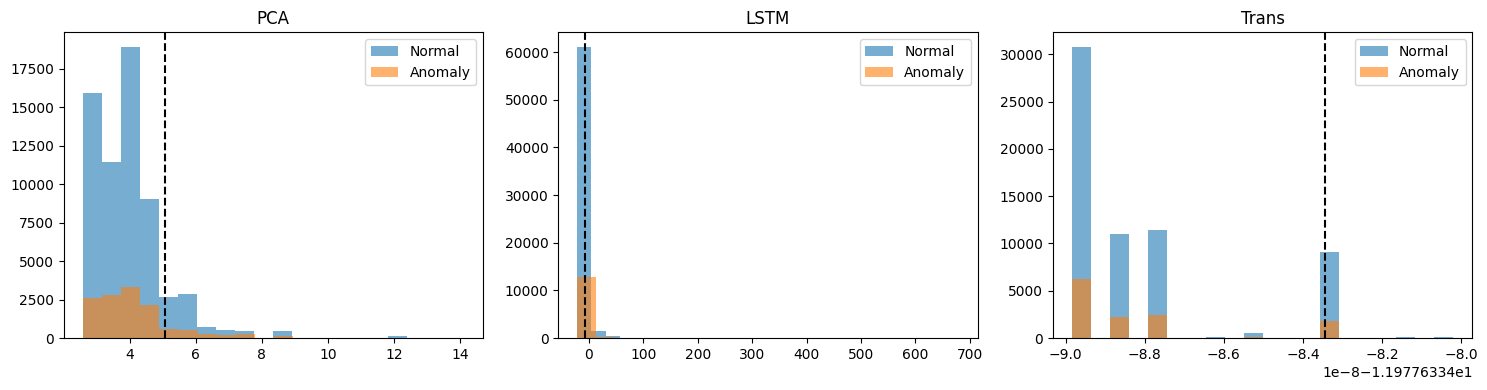

In [34]:
#!/usr/bin/env python3
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# --- Your features & target ---
classification_features = ['Activity Strain', 'Average HR (bpm)_x']
classification_target   = 'Answered yes'

# --- 1. Load & Clean Data ---
FILE_PATH = '/content/drive/MyDrive/Sports_AI/Final_Labeled_Scored_Data.xlsx'
df = pd.read_excel(FILE_PATH)

# Keep only rows with a valid target
df = df[df[classification_target].notna()]
y_all = df[classification_target].astype(int).values

# Select and impute your two features
X_df = df[classification_features].fillna(df[classification_features].mean())
X_all = X_df.values

print(f"After cleaning: {X_all.shape[0]} rows, {X_all.shape[1]} features.")

# --- 2. Build rolling 4-week sequences ---
WINDOW = 4
if len(X_all) < WINDOW:
    raise ValueError(f"Need ≥{WINDOW} rows; got {len(X_all)}.")

X_seq, y_seq = [], []
for i in range(len(X_all) - WINDOW + 1):
    X_seq.append(X_all[i : i + WINDOW])
    y_seq.append(y_all[i + WINDOW - 1])
X_seq = np.stack(X_seq, axis=0)   # (N_windows, 4, 2)
y_seq = np.array(y_seq, dtype=int)

print(f"Built sequences: {X_seq.shape}, label dist: {np.bincount(y_seq)}")

# Standardize
scaler = StandardScaler()
N, T, D = X_seq.shape
X_seq = scaler.fit_transform(X_seq.reshape(-1, D)).reshape(N, T, D)

# DataLoader
loader = DataLoader(TensorDataset(torch.from_numpy(X_seq).float()), batch_size=8, shuffle=True)

# --- 3. PCA + GMM on flattened 4×2 data ---
X_flat = X_seq.reshape(N, -1)
pca   = PCA(n_components=min(2, X_flat.shape[1]))
X_pca = pca.fit_transform(X_flat)

gmm_pca    = GaussianMixture(n_components=2, random_state=42)
gmm_pca.fit(X_pca)                            # <— Fit before scoring
scores_pca = -gmm_pca.score_samples(X_pca)
thr_pca    = np.percentile(scores_pca, 90)
preds_pca  = (scores_pca > thr_pca).astype(int)

# --- 4. LSTM-Autoencoder + GMM ---
class LSTMAE(nn.Module):
    def __init__(self, feat_dim, hid_dim=16):
        super().__init__()
        self.enc = nn.LSTM(feat_dim, hid_dim, batch_first=True)
        self.dec = nn.LSTM(hid_dim, feat_dim, batch_first=True)
    def forward(self, x):
        _, (h, _) = self.enc(x)
        rep = h.repeat(x.size(1),1,1).permute(1,0,2)
        out, _ = self.dec(rep)
        return out

lstm_model = LSTMAE(feat_dim=D)
opt_lstm    = torch.optim.Adam(lstm_model.parameters(), lr=1e-3)
mse_loss    = nn.MSELoss()

# Train LSTM-AE
lstm_model.train()
for ep in range(10):
    total = 0
    for (bx,) in loader:
        opt_lstm.zero_grad()
        out = lstm_model(bx)
        loss = mse_loss(out, bx)
        loss.backward()
        opt_lstm.step()
        total += loss.item()
    print(f"[LSTM] Epoch {ep+1} Loss {total:.4f}")

# Extract hidden embeddings
lstm_model.eval()
emb_lstm = []
with torch.no_grad():
    for (bx,) in loader:
        _, (h, _) = lstm_model.enc(bx)
        emb_lstm.append(h.squeeze(0))
emb_lstm = torch.cat(emb_lstm, dim=0).numpy()

gmm_lstm     = GaussianMixture(n_components=2, random_state=42)
gmm_lstm.fit(emb_lstm)                        # <— Fit before scoring
scores_lstm  = -gmm_lstm.score_samples(emb_lstm)
thr_lstm     = np.percentile(scores_lstm, 90)
preds_lstm   = (scores_lstm > thr_lstm).astype(int)

# --- 5. Time-Aware Transformer + GMM ---
class TimeAwareTransformer(nn.Module):
    def __init__(self, feat_dim, heads=2, layers=1):
        super().__init__()
        self.cls = nn.Parameter(torch.randn(1,1,feat_dim))
        self.pos = nn.Parameter(torch.randn(1,WINDOW+1,feat_dim))
        enc = nn.TransformerEncoderLayer(d_model=feat_dim, nhead=heads, batch_first=True)
        self.tr = nn.TransformerEncoder(enc, num_layers=layers)
    def forward(self, x):
        B = x.size(0)
        cls = self.cls.expand(B,-1,-1)
        seq = torch.cat([cls, x], dim=1) + self.pos
        return self.tr(seq)[:,0]

trans_model = TimeAwareTransformer(feat_dim=D)
opt_tr      = torch.optim.Adam(trans_model.parameters(), lr=1e-4)

# Train Transformer
trans_model.train()
for ep in range(10):
    total = 0
    for (bx,) in loader:
        opt_tr.zero_grad()
        mask    = torch.rand_like(bx) < 0.15
        emb_m   = trans_model(bx.masked_fill(mask, 0))
        emb_f   = trans_model(bx)
        loss    = mse_loss(emb_m, emb_f)
        loss.backward()
        opt_tr.step()
        total += loss.item()
    print(f"[Trans] Epoch {ep+1} Loss {total:.4f}")

# Extract Transformer embeddings
trans_model.eval()
emb_tr = []
with torch.no_grad():
    for (bx,) in loader:
        emb_tr.append(trans_model(bx))
emb_tr = torch.cat(emb_tr, dim=0).numpy()

gmm_tr     = GaussianMixture(n_components=2, random_state=42)
gmm_tr.fit(emb_tr)                            # <— Fit before scoring
scores_tr  = -gmm_tr.score_samples(emb_tr)
thr_tr     = np.percentile(scores_tr, 90)
preds_tr   = (scores_tr > thr_tr).astype(int)

# --- 6. Evaluate & Export ---
def eval_metrics(scores, preds):
    return {
        'Precision': precision_score(y_seq, preds),
        'Recall':    recall_score(y_seq, preds),
        'F1':        f1_score(y_seq, preds),
        'AUC':       roc_auc_score(y_seq, scores)
    }

results = {
    'PCA+GMM':        eval_metrics(scores_pca, preds_pca),
    'LSTM+GMM':       eval_metrics(scores_lstm, preds_lstm),
    'Transformer+GMM': eval_metrics(scores_tr, preds_tr)
}

res_df = pd.DataFrame(results).T
res_df.to_excel("benchmark_results.xlsx", index=True)
print("\nBenchmark Results:\n", res_df)

# --- 7. Plot score distributions ---
fig, axes = plt.subplots(1,3,figsize=(15,4))
for ax, (name, scores, thr) in zip(axes, [
    ('PCA', scores_pca, thr_pca),
    ('LSTM', scores_lstm, thr_lstm),
    ('Trans', scores_tr, thr_tr)
]):
    ax.hist(scores[y_seq==0], bins=20, alpha=0.6, label='Normal')
    ax.hist(scores[y_seq==1], bins=20, alpha=0.6, label='Anomaly')
    ax.axvline(thr, color='k', linestyle='--')
    ax.set_title(name)
    ax.legend()
plt.tight_layout()
plt.savefig("score_distributions.png")
plt.show()

